In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import inception
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
#test = pd.read_json(BASE_dir + 'test.json')

In [3]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                rotate = np.random.randint(4, size=1)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
                pass
        img = torch.from_numpy(img).type(dtype)
        img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

# def data_aug(X, y):    
#     X_rot_30 = []
#     X_rot_60 = [] 
#     X_h = np.flip(X, 3)
#     X_v = np.flip(X, 2)
#     for i in X:
#         X_rot_30.append(tf.rotate(i,angle=30,resize=False))
#         X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
#     X_rot_30 = np.stack(X_rot_30)
#     X_rot_60 = np.stack(X_rot_60)
#     ch_y = np.concatenate((y,y,y,y,y))
#     ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
#     return ch_X, ch_y

def data_aug(X, y):    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=90,resize=False))
        X_rot_60.append(tf.rotate(i,angle=270,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


def data_aug2(X, y):    
    X_rot_90 = []
    X_rot_180 = []
    X_rot_270 = []
    X_rot_90_hflip = []
    X_rot_270_hflip = []
    
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_90.append(tf.rotate(i,angle=90,resize=False))
        X_rot_180.append(tf.rotate(i,angle=180,resize=False))
        X_rot_270.append(tf.rotate(i,angle=270,resize=False))
        X_rot_90_hflip.append(np.flip(tf.rotate(i,angle=90,resize=False),2))
        X_rot_270_hflip.append(np.flip(tf.rotate(i,angle=270,resize=False),2))
    
    
    X_rot_90 = np.stack(X_rot_90)
    X_rot_180 = np.stack(X_rot_180)
    X_rot_270 = np.stack(X_rot_270 )
    X_rot_90_hflip = np.stack(X_rot_90_hflip)
    X_rot_270_hflip = np.stack(X_rot_270_hflip)
    
    ch_y = np.concatenate((y,y,y,y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v,X_rot_90,X_rot_180,X_rot_270,X_rot_90_hflip,X_rot_270_hflip))
    return ch_X, ch_y





train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [18]:
#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
sum(np.where(data.inc_angle > 0)[0])

1470

In [4]:
train_X_del = train_X[data.inc_angle!='na',:,:,:]
train_y_del = train_y[data.inc_angle!='na']
result = []
for num,i in enumerate(train_X_del):
    temp = []
    for j in i:
        temp.append(tf.rescale(j,299/75,mode='constant'))
    img = np.stack(temp)
    result.append(img)
    if num%50==0:
        print('We are %d'%num)
train_X_del = np.stack(result)

We are 0
We are 50
We are 100
We are 150
We are 200
We are 250
We are 300
We are 350
We are 400
We are 450
We are 500
We are 550
We are 600
We are 650
We are 700
We are 750
We are 800
We are 850
We are 900
We are 950
We are 1000
We are 1050
We are 1100
We are 1150
We are 1200
We are 1250
We are 1300
We are 1350
We are 1400
We are 1450


In [5]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
# train_index=list(range(304,1604)) 
# val_index= list(range(304))
# # train_X[train_index].shape

# # seed= np.random.RandomState(123)
# # spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# # train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_X_del = train_X[data.inc_angle!='na',:,:,:]
# train_y_del = train_y[data.inc_angle!='na']
# result = []
# for i in train_X_del:
#     temp = []
#     for j in i:
#         temp.append(tf.rescale(i,299/75,mode='constant'))
#     img = np.stack(temp)
#     result.append(img)
# train_X_del = np.stack(result)
# # train_X_del = train_X
# # train_y_del = train_y

seed= np.random.RandomState(123)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
train_index, val_index = next(spliter.split(train_X_del))
# # train_index=list(range(284,1471)) 
# # val_index= list(range(284))

train_mean, train_std = transform_compute(train_X_del[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])
#af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
#af_train_X, af_train_y = data_aug2(train_X_del[train_index], train_y_del[train_index])
af_train_X, af_train_y = train_X_del[train_index], train_y_del[train_index]

train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

###########################################################################
# train_index=list(range(1604)) 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])


# train_X_del = train_X#[data.inc_angle!='na',:,:,:]
# train_y_del = train_y#[data.inc_angle!='na']

## For final training
# train_X_del = train_X[data.inc_angle!='na',:,:,:]
# train_y_del = train_y[data.inc_angle!='na']

# train_mean, train_std = transform_compute(train_X_del)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])


In [23]:
# torch.cuda.is_available()
# torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
# train_X[1]
# use_cuda
optimizer.param_groups[0]['lr']

0.0005

In [9]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'incep_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'incep_loss.pth')
#             if loss_avg/total >val_loss:
#                 e_s =0
                
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss,best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [10]:
result = []
wd = [0.0001,0.00005]
for i in range(2):
    incep_net = inception.inception_v3(num_classes=2,aux_logits=False)
    net= incep_net

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=wd[i], nesterov= True)
#     optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.0000)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.000001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   

    result.append(train(epoch=200,early_stopping= 20))


This is epoch:1
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s6ms|Loss: 0.817 | Acc: 64.201% (755/1176)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 5.375 | Acc: 56.949% (168/295)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s6ms|Loss: 0.667 | Acc: 70.408% (828/1176)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.547 | Acc: 69.492% (205/295)
acc: Save it!

This is epoch:3
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s6ms|Loss: 0.567 | Acc: 70.833% (833/1176)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.470 | Acc: 71.864% (212/295)
acc: Save it!

This is epoch:4
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s6ms|Loss: 0.495 | Acc: 75.085% (883/1176)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.389 | Acc: 83.051% (245/295)
acc: Save it!

This is epoch:5
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s6ms|Loss: 0.476 | Acc: 78.656% (925/1176)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.421 | Acc: 79.661%

Process Process-1815:
Process Process-1814:
Process Process-1813:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/

KeyboardInterrupt: 

In [8]:
result

[(92.20338983050847, 93)]

In [ ]:
##For continue training
net = cnn.plain_cnn(num_classes=2)
 
net.load_state_dict(torch.load('cnn_loss.pth'))


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()

result = train(epoch=250,early_stopping= 20)


# test_set = pd.read_json(BASE_dir + 'test.json')
# test_X = raw_to_numpy(test_set)
# test_X.shape 
# fake_label = np.zeros(len(test_X))

# test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

# test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
# result = []
# for i in range(10):
#     train(epoch=1)

#     prob = [] 
#     net.eval()
#     for k, (val_x, val_y) in enumerate(test_loader):
#         if use_cuda:
#             val_x, val_y = val_x.cuda(), val_y.cuda()
#         x = Variable(val_x)
#         y = Variable(val_y)
#         out = net(x)
#         #prevent overflow
#         temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
#         ans= temp[:,1]/(temp.sum(axis=1))
#         prob.append(ans)
#         #print(out.size())
#         progress_bar(k, len(test_loader))
#     result.append(np.concatenate(prob))

In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

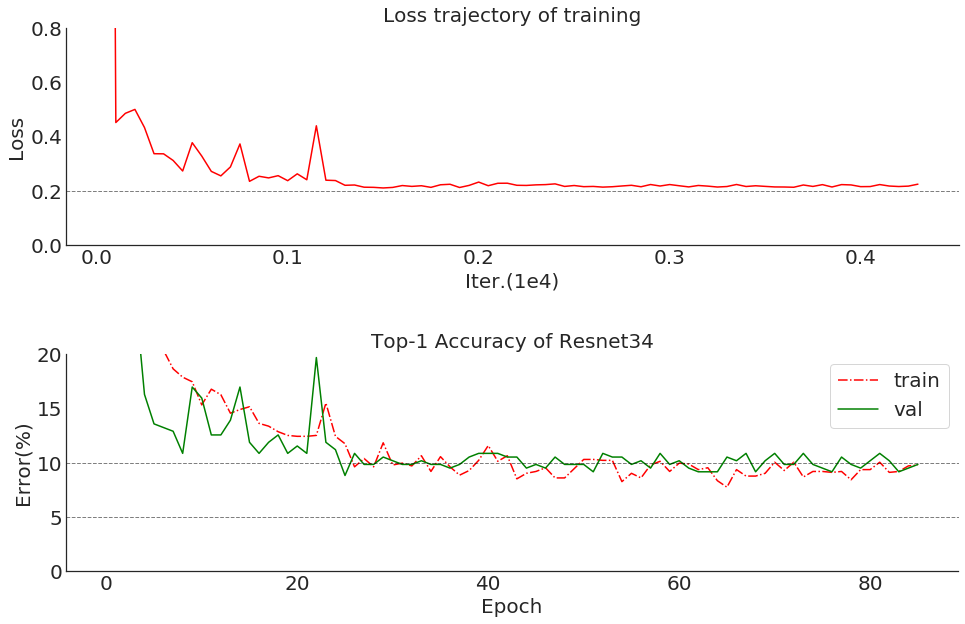

In [11]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.8))
fig1.axhline(y=[0.2],alpha=0.5, linestyle='--',color='k',linewidth=1)

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet34',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

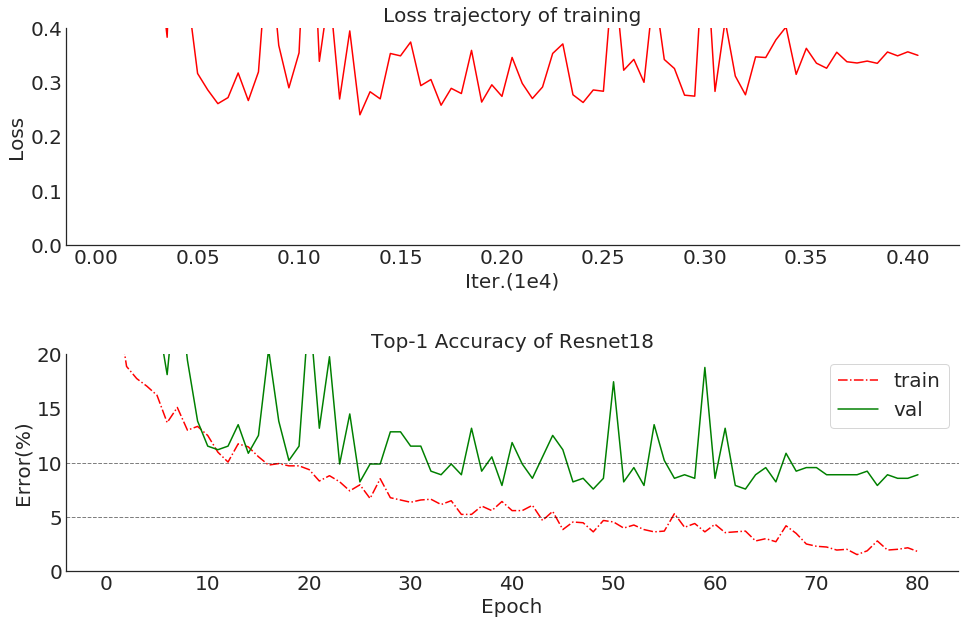

In [12]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [8]:
net = cnn.plain_cnn(num_classes=2)
net.load_state_dict(torch.load('save_cnn_loss20_1.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms


In [77]:
k =np.stack(result).mean(axis=0)
# #sub.shapesub.to_csv('submission2.csv',index=False)
# result[1].shape
# np.concatenate(prob).shape

In [9]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] =  np.concatenate(prob)
sub.shape
sub.to_csv('submissioniu.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [5]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'incep_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                acc= best_acc+0.01
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'incep_loss.pth')
            if loss_avg/total >val_loss:
                e_s = 0
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

#Try different transformation

for rou in range(2):
    rou +=1
    ran_num = np.random.randint(30000,40000,size=1)
    if rou ==1:
        ran_num= 33864
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        if k in [0,1] and rou ==1:
            print('We skip the first round')
            continue
        train_mean, train_std = transform_compute(train_X_del[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])
        #af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
        af_train_X, af_train_y = train_X_del[train_index], train_y_del[train_index]
        
        train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        
        candidate = []
        for rep in range(2):
            incep_net = inception.inception_v3(num_classes=2,aux_logits=False)
            net= incep_net

            criterion = nn.CrossEntropyLoss()

            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00005, nesterov= True)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.000001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()

            result = train(epoch=150,early_stopping= 20)
            candidate.append(result[0])
            with open("incep_models/log.txt", "a") as myfile:
                msg = 'Phase1, At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp incep_loss.pth incep_loss{}.pth'.format(rep)
            os.system(cmd)
#             if len(candidate)==2:
#                 if np.sum(np.array(candidate)<0.18)>=1:
#                     continue
#                 else:
#                     break
#         if min(candidate)>0.2:
#             with open("plain_cnn_models/log.txt", "a") as myfile:
#                 msg = 'We are going to give up this round\n'
#                 myfile.write(msg)
                
#             g= candidate.index(min(candidate))
#             cmd = 'cp cnn_loss{}.pth plain_cnn_models_lossbackup/cnn{}_{}{}.pth'.format(g,rou,k,g)
#             os.system(cmd)
#             continue

        #actually an array
        #also change here
        final_list = np.union1d(np.where(np.array(candidate) <0.18)[0], [candidate.index(min(candidate))])
        final_list_v=[i for i in range(len(candidate)) if i not in final_list]
        #final_list = list(range(len(candidate)))
        
        word= ''
        for i in np.array(candidate)[final_list]:
            word = word +', '+ str(i)
        
        
        for g in final_list:
            with open("incep_models/result.txt", "a") as myfile:
                msg = 'Phase1, At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                            k,ran_num,rep+1, len(final_list), word)
                myfile.write(msg)
            cmd = 'cp incep_loss{}.pth incep_models/r1_incep{}_{}{}[good].pth'.format(g,rou,k,g)
            os.system(cmd)
        for g in final_list_v:
            with open("incep_models/result.txt", "a") as myfile:
                msg = 'Phase1, At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                            k,ran_num,rep+1, len(final_list), word)
                myfile.write(msg)
            cmd = 'cp incep_loss{}.pth incep_models/r1_incep{}_{}{}[bad].pth'.format(g,rou,k,g)
            os.system(cmd)
        print('We are over this round!')

We skip the first round
We skip the first round

This is epoch:1
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s8ms|Loss: 0.789 | Acc: 63.806% (751/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 11.833 | Acc: 55.442% (163/294)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s8ms|Loss: 0.668 | Acc: 68.139% (802/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.549 | Acc: 75.850% (223/294)
acc: Save it!

This is epoch:3
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s8ms|Loss: 0.601 | Acc: 68.904% (811/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.501 | Acc: 73.469% (216/294)

This is epoch:4
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s7ms|Loss: 0.567 | Acc: 72.048% (848/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.428 | Acc: 78.912% (232/294)
acc: Save it!

This is epoch:5
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s7ms|Loss: 0.554 | Acc: 73.747% (868/1177)
[=========   5/  5 ==>....]Step: 1ms| 

Process Process-3708:
Process Process-3707:
Process Process-3706:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.5

KeyboardInterrupt: 

In [5]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'incep_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                acc= best_acc+0.01
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'incep_loss.pth')
            if loss_avg/total >val_loss:
                e_s = 0
            if loss_avg/total < 0.155:
                print('Big save')
                torch.save(net.state_dict(), 'incep_loss_spec2.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

ran_num = 33864
seed= np.random.RandomState(ran_num)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
    if k!=4:
        continue
    train_mean, train_std = transform_compute(train_X_del[train_index])
    train_transform = T.Compose([
        T.Normalize(train_mean, train_std)
    ])
    #af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
    af_train_X, af_train_y = train_X_del[train_index], train_y_del[train_index]
        
    train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
    val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

    train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

    candidate = []

    incep_net = inception.inception_v3(num_classes=2,aux_logits=False)
    net= incep_net
    net.load_state_dict(torch.load('incep_models/r1_incep1_41[good].pth'))
    #net.load_state_dict(torch.load('incep_loss_spec.pth'))
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0001, nesterov= True)
    #optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=0.00003)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.00001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()

    result = train(epoch=150,early_stopping= 20)
    candidate.append(result[0])
    with open("incep_models/log.txt", "a") as myfile:
        msg = 'Phase1, At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                    k,ran_num,rep+1, result[1], result[0])
        myfile.write(msg)
    cmd = 'cp incep_loss.pth incep_loss{}.pth'.format(rep)
    os.system(cmd)


This is epoch:1
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s7ms|Loss: 0.159 | Acc: 93.118% (1096/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.217 | Acc: 89.796% (264/294)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s8ms|Loss: 0.158 | Acc: 93.288% (1098/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.220 | Acc: 90.136% (265/294)
acc: Save it!

This is epoch:3
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s7ms|Loss: 0.185 | Acc: 92.353% (1087/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.221 | Acc: 89.456% (263/294)

This is epoch:4
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s7ms|Loss: 0.164 | Acc: 92.693% (1091/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.216 | Acc: 90.136% (265/294)
loss: Save it!

This is epoch:5
[=========  37/ 37 ======>]Step: 2ms| Tot: 9s7ms|Loss: 0.159 | Acc: 93.883% (1105/1177)
[=========   5/  5 ==>....]Step: 1ms| Tot: 5ms|Loss: 0.216 | Acc: 90.476% (266/29

Process Process-181:
Process Process-182:
Process Process-183:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "

KeyboardInterrupt: 

In [15]:
ran_num = 33864
seed= np.random.RandomState(ran_num)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
    if k!=0:
        continue
    print(val_index)s

[   6    9   10   13   25   26   35   42   43   44   46   54   64   70   80
   81   92  103  109  112  113  124  133  137  143  148  160  166  180  181
  187  191  192  194  200  207  208  214  216  219  224  226  227  234  244
  248  249  250  251  255  256  265  267  268  273  274  281  285  287  288
  299  306  310  313  318  319  326  329  337  345  347  351  354  356  366
  374  376  387  396  398  421  425  430  439  442  449  451  455  457  461
  462  471  478  481  486  487  504  511  512  513  518  522  523  528  529
  530  531  536  542  546  554  556  564  585  586  598  602  603  605  608
  614  621  623  624  649  650  651  653  656  657  659  660  662  663  665
  671  673  686  690  697  699  700  702  715  725  733  738  743  750  758
  759  760  763  764  768  772  777  779  783  795  796  800  813  819  826
  835  838  839  842  851  855  857  862  864  865  866  873  875  876  884
  889  890  892  897  904  908  909  913  921  927  934  937  944  953  954
  961  967  

In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [25]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']#temp11.mean(axis=1)#temp11['is_iceberg33']
sub.shape
sub.to_csv('submissiony.csv',index=False)

In [6]:
net = cnn.plain_cnn(num_classes=2)
net.load_state_dict(torch.load('plain_cnn_models/cnn_loss2.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

temp11=pd.DataFrame()
prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[========= 132/132 ======>]Step: 0ms| Tot: 1s2ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [5]:
train_mean, train_std = transform_compute(train_X_del)
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

temp11 = pd.DataFrame()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))
train=0
train_X_del=0
data=0

In [6]:
test=0
result = []
for num,i in enumerate(test_X):
    temp = []
    for j in i:
        temp.append(tf.rescale(j,299/75,mode='constant'))
    img = np.stack(temp)
    result.append(img)
    if num%100==0:
        print('We are %d'%num)
test_X = np.stack(result)

We are 0
We are 100
We are 200
We are 300
We are 400
We are 500
We are 600
We are 700
We are 800
We are 900
We are 1000
We are 1100
We are 1200
We are 1300
We are 1400
We are 1500
We are 1600
We are 1700
We are 1800
We are 1900
We are 2000
We are 2100
We are 2200
We are 2300
We are 2400
We are 2500
We are 2600
We are 2700
We are 2800
We are 2900
We are 3000
We are 3100
We are 3200
We are 3300
We are 3400
We are 3500
We are 3600
We are 3700
We are 3800
We are 3900
We are 4000
We are 4100
We are 4200
We are 4300
We are 4400
We are 4500
We are 4600
We are 4700
We are 4800
We are 4900
We are 5000
We are 5100
We are 5200
We are 5300
We are 5400
We are 5500
We are 5600
We are 5700
We are 5800
We are 5900
We are 6000
We are 6100
We are 6200
We are 6300
We are 6400
We are 6500
We are 6600
We are 6700
We are 6800
We are 6900
We are 7000
We are 7100
We are 7200
We are 7300
We are 7400
We are 7500
We are 7600
We are 7700
We are 7800
We are 7900
We are 8000
We are 8100
We are 8200
We are 8300
We a

In [29]:

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

#waiting_list = [os.path.join('plain_cnn_models',i) for i in os.listdir(path='plain_cnn_models') if '.pth' in i and 'r3_cnn3' in i]

#waiting_list =[os.path.join('incep_models',i) for i in os.listdir(path='incep_models') if 'retrain' in i]

waiting_list= ['r1_incep1_10[good].pth',
'r1_incep1_11[bad].pth',
'r1_incep1_30[good].pth',
'r1_incep1_31[bad].pth',
'r1_incep1_40[bad].pth',
'r1_incep1_41[good].pth',
'r1_incep_loss0_00[bad].pth',
'r1_incep_loss0_01[good].pth']

waiting_list =[os.path.join('incep_models',i) for i in os.listdir(path='incep_models') if i in waiting_list]
print(waiting_list)
for i,pth in enumerate(waiting_list):
    net = inception.inception_v3(num_classes=2,aux_logits=False)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % int(i+6)
    temp11[msg]=np.concatenate(prob)

['incep_models/r1_incep1_31[bad].pth', 'incep_models/r1_incep1_10[good].pth', 'incep_models/r1_incep1_30[good].pth', 'incep_models/r1_incep_loss0_00[bad].pth', 'incep_models/r1_incep_loss0_01[good].pth', 'incep_models/r1_incep1_41[good].pth', 'incep_models/r1_incep1_11[bad].pth', 'incep_models/r1_incep1_40[bad].pth']
[========= 132/132 ======>]Step: 1ms| Tot: 21s6ms
[========= 132/132 ======>]Step: 1ms| Tot: 21s8ms
[========= 132/132 ======>]Step: 1ms| Tot: 22s9ms
[========= 132/132 ======>]Step: 1ms| Tot: 21s6ms
[========= 132/132 ======>]Step: 1ms| Tot: 21s6ms
[========= 132/132 ======>]Step: 1ms| Tot: 21s5ms
[========= 132/132 ======>]Step: 1ms| Tot: 21s3ms
[========= 132/132 ======>]Step: 1ms| Tot: 21s2ms


In [7]:
# import pickle 
# with open('incep_299_testdata.pkl','wb') as f:
#     pickle.dump(test_X,f)

OverflowError: cannot serialize a bytes object larger than 4 GiB

In [8]:
waiting_list = [os.path.join('plain_cnn_models',i) for i in os.listdir(path='plain_cnn_models') if '.pth' in i and 'good' in i]
for i in waiting_list:
    print(i)
len(waiting_list)

plain_cnn_models/r3_cnn2_20[good].pth
plain_cnn_models/r3_cnn2_01[good].pth
plain_cnn_models/r3_cnn3_20[good].pth
plain_cnn_models/r3_cnn0_30[good].pth
plain_cnn_models/r2_cnn0_31[good].pth
plain_cnn_models/r3_cnn3_30[good].pth
plain_cnn_models/r3_cnn1_20[good].pth
plain_cnn_models/r3_cnn0_10[good].pth
plain_cnn_models/r3_cnn2_00[good].pth
plain_cnn_models/r3_cnn0_32[good].pth
plain_cnn_models/r3_cnn3_41[good].pth
plain_cnn_models/r3_cnn3_42[good].pth
plain_cnn_models/r3_cnn3_40[good].pth
plain_cnn_models/r3_cnn3_31[good].pth
plain_cnn_models/r3_cnn2_11[good].pth
plain_cnn_models/r3_cnn1_32[good].pth
plain_cnn_models/r3_cnn0_12[good].pth
plain_cnn_models/r3_cnn0_11[good].pth
plain_cnn_models/r3_cnn2_12[good].pth
plain_cnn_models/r3_cnn2_02[good].pth
plain_cnn_models/r3_cnn0_21[good].pth
plain_cnn_models/r2_cnn0_11[good].pth
plain_cnn_models/r3_cnn1_41[good].pth
plain_cnn_models/r2_cnn0_41[good].pth
plain_cnn_models/r3_cnn1_31[good].pth
plain_cnn_models/r2_cnn0_12[good].pth
plain_cnn_mo

31

In [34]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11.mean(axis=1)#temp12['is_iceberg']#temp11.mean(axis=1)#temp11['is_iceberg']
sub.shape
sub.to_csv('submissionppi.csv',index=False)

In [18]:
# result = temp11.mean(1)
# temp11.head()
#temp12= pd.read_csv('36_plain_cnn.csv')
# temp12['is_iceberg40'] = temp11.mean(axis=1)
# temp12.corr()
# test_X = np.stack(result[:2106])
# len(result)
a = [1,2,3]
a[1:5]

[2, 3]

In [23]:
temp12['is_iceberg_max'] = temp11.iloc[:, :6].max(axis=1)
temp12['is_iceberg_min'] = temp11.iloc[:, :41].min(axis=1)
temp12['is_iceberg_median'] = temp11.iloc[:, :41].median(axis=1)
temp12['is_iceberg_mean'] = temp11.iloc[:, :41].mean(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

#temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp12['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:41] > cutoff_lo, axis=1), 
                                    temp12['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:41] < cutoff_hi, axis=1),
                                             temp12['is_iceberg_min'], 
                                             temp12['is_iceberg_median']))

NameError: name 'temp12' is not defined

In [24]:
temp11['is_iceberg_max'] = temp11.iloc[:, :6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :6].median(axis=1)
temp11['is_iceberg_mean'] = temp11.iloc[:, :6].mean(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

#temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_median']))

In [22]:
#np.sum((temp11.iloc[:,:67]<0.1).apply(np.sum,axis=1)==67)
np.sum((temp11.iloc[:,:6]<0.2).apply(np.sum,axis=1)==6)

3235

In [31]:
#temp11 =pd.read_csv('6_retrain_inception.csv')
#temp11.columns
temp11.corr()
temp11.to_csv('all_14_inception.csv',index=False)

In [12]:
#temp11.to_csv('67_plain_cnn.csv',index=False)
#temp12.to_csv('41_plain_cnn.csv',index=False)
#test = pd.read_json(BASE_dir + 'test.json')